In [146]:
import tensorflow as tf
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [147]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [148]:
t = pd.read_csv('/home/mrrumpf/build/planb/vscode-template-linux/2338365-no-nans.csv')
df = t[['DATE','HourlyDryBulbTemperature']]
date_time = pd.to_datetime(df.pop('DATE'), format='%Y-%m-%d %H:%M:%S')
print(df)

       HourlyDryBulbTemperature
0                            40
1                            39
2                            39
3                            39
4                            39
...                         ...
68814                        64
68815                        62
68816                        61
68817                        60
68818                        59

[68819 rows x 1 columns]


In [149]:
uni_data = df['HourlyDryBulbTemperature']
uni_data.head()

0    40
1    39
2    39
3    39
4    39
Name: HourlyDryBulbTemperature, dtype: int64

array([<AxesSubplot:>], dtype=object)

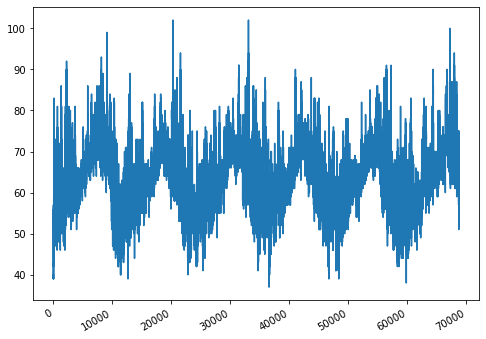

In [150]:
uni_data.plot(subplots=True)

In [151]:
uni_data = uni_data.values

In [152]:
# 2121 datapoints (days)
# .70 == training data = 1484
# .15 == validation data = 318
# .15 == test data = 318
TRAIN_SPLIT = 48000

In [153]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [154]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [155]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [156]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-3.12743651]
 [-3.26373708]
 [-3.26373708]
 [-3.26373708]
 [-3.26373708]
 [-3.26373708]
 [-3.26373708]
 [-2.71853479]
 [-2.03703193]
 [-1.49182964]
 [-1.2192285 ]
 [-0.81032678]
 [-0.94662735]
 [-0.94662735]
 [-0.94662735]
 [-1.08292792]
 [-1.35552907]
 [-1.76443079]
 [-2.03703193]
 [-2.03703193]]

 Target temperature to predict
-2.1733325020993792


In [157]:
def create_time_steps(length):
  return list(range(-length, 0))

In [158]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/home/mrrumpf/venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

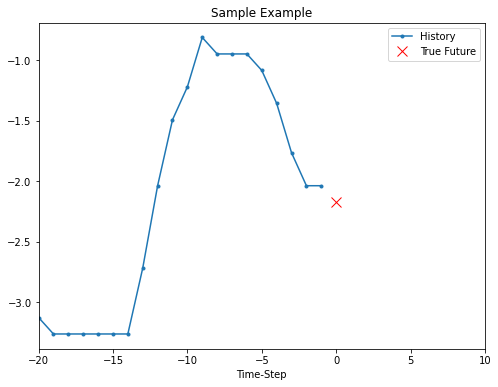

In [159]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')


In [160]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/home/mrrumpf/venv/lib/python3.8/site-packages/matplotlib/pyplot.py'>

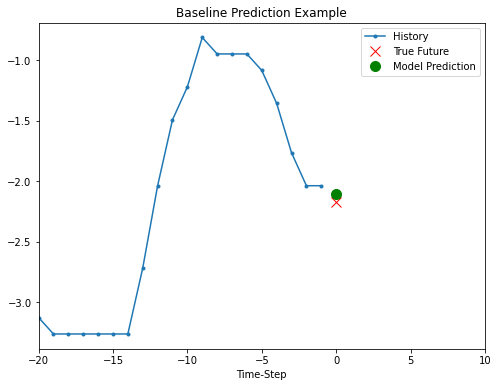

In [161]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [162]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [163]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [164]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [165]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 2s 10ms/step - loss: 0.5274 - val_loss: 0.3309
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.2480 - val_loss: 0.1718
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1589 - val_loss: 0.1407
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1403 - val_loss: 0.1298
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1325 - val_loss: 0.1249
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1289 - val_loss: 0.1230
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1271 - val_loss: 0.1218
Epoch 8/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1261 - val_loss: 0.1208
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1259 - val_loss: 0.1214
Epoch 10/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1247 - val_loss: 0.119

In [124]:
simple_lstm_model.save('/home/mrrumpf/build/planb/vscode-template-linux/planb.tfmodel')

INFO:tensorflow:Assets written to: /home/mrrumpf/build/planb/vscode-template-linux/planb.tfmodel/assets


INFO:tensorflow:Assets written to: /home/mrrumpf/build/planb/vscode-template-linux/planb.tfmodel/assets


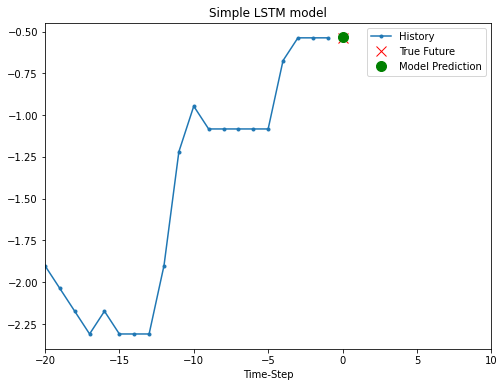

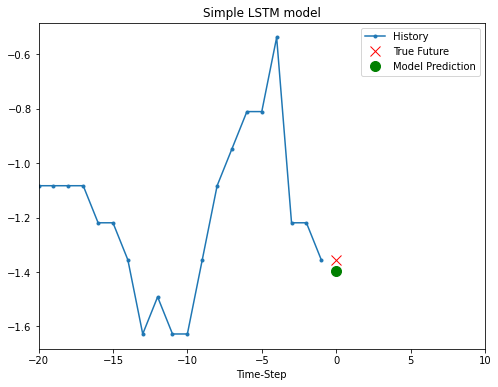

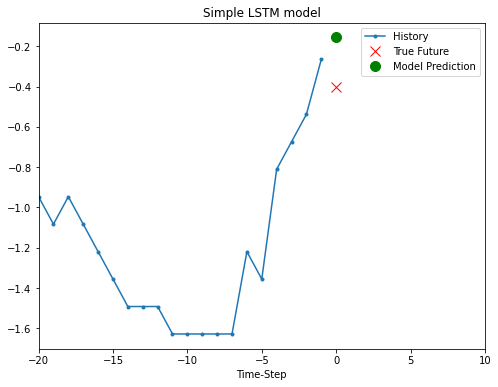

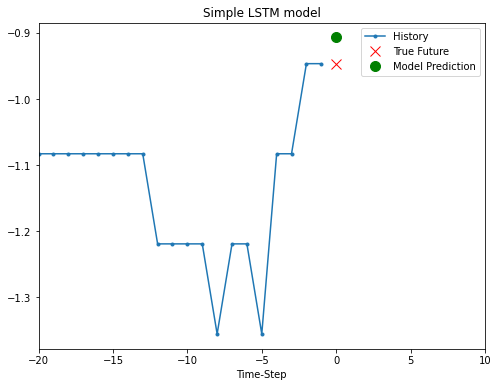

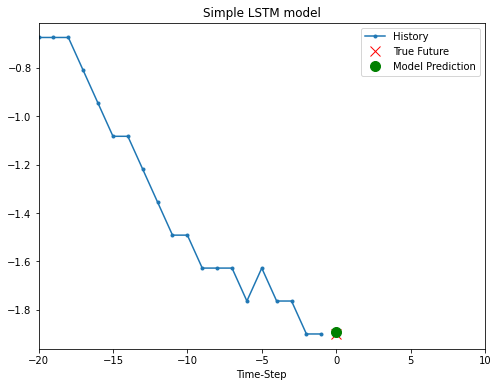

In [125]:
for x, y in val_univariate.take(5):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [126]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model("/home/mrrumpf/build/planb/vscode-template-linux/planb.tfmodel")
model_no_quant_tflite = converter.convert()

# Save the model to disk
open("/home/mrrumpf/build/planb/vscode-template-linux/planb.tflite", "wb").write(model_no_quant_tflite)

21048

In [127]:
################
# CNN ATTEMPT
################

In [138]:
# convert date time to string form
timestamp_s = date_time.map(datetime.datetime.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

<ipython-input-138-447fae9f0d33>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
<ipython-input-138-447fae9f0d33>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
<ipython-input-138-447fae9f0d33>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

Text(0.5, 1.0, 'Time of day signal')

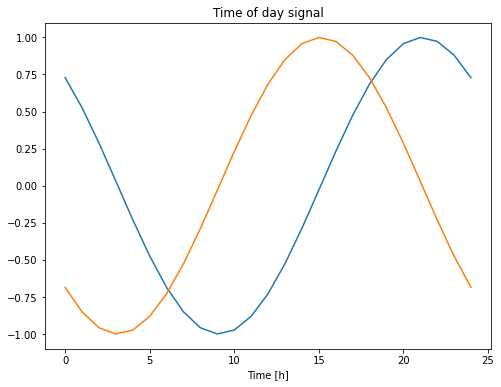

In [145]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [139]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [140]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [141]:
OUT_STEPS=24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

In [142]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [143]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [144]:
column_indices = {name: i for i, name in enumerate(df.columns)}
print(df)
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

# CNN
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

       HourlyDryBulbTemperature   Day sin   Day cos  Year sin  Year cos
0                            40  0.728371 -0.685183  0.007873  0.999969
1                            39  0.526214 -0.850352  0.008589  0.999963
2                            39  0.288196 -0.957571  0.009306  0.999957
3                            39  0.030539 -0.999534  0.010023  0.999950
4                            39 -0.229200 -0.973379  0.010740  0.999942
...                         ...       ...       ...       ...       ...
68814                        64  0.685183  0.728371 -0.877597  0.479398
68815                        62  0.850352  0.526214 -0.877254  0.480027
68816                        61  0.957571  0.288196 -0.876909  0.480656
68817                        60  0.999534  0.030539 -0.876565  0.481284
68818                        59  0.973379 -0.229200 -0.876219  0.481912

[68819 rows x 5 columns]


AttributeError: module 'tensorflow.keras.preprocessing' has no attribute 'timeseries_dataset_from_array'